In [1]:
# Stephen.Griffies@noaa.gov
# SST from models and observational products 

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
%matplotlib inline

from datetime import timedelta

print("numpy version  : ", np.__version__)
print("pandas version : ", pd.__version__)
print("xarray version : ", xr.__version__)

numpy version  :  1.23.5
pandas version :  2.0.0
xarray version :  2023.4.2


In [3]:
sns.set_style('white')
sns.set_context('paper', font_scale=3)
sns.set_palette('hls', 6)
sns.set_style('ticks')

In [4]:
def weighted_temporal_mean(ds, var):
  """
  weight by days in each month
  """
  # Determine the month length
  month_length = ds.time.dt.days_in_month

  # Calculate the weights
  wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

  # Make sure the weights in each year add up to 1
  np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

  # Subset our dataset for our variable
  obs = ds[var]

  # Setup our masking for nan values
  cond = obs.isnull()
  ones = xr.where(cond, 0.0, 1.0)

  # Calculate the numerator
  obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

  # Calculate the denominator
  ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

  # Return the weighted average
  return obs_sum / ones_out

In [5]:
oisst = xr.open_dataset(
    "https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc",
    use_cftime=True,chunks={"time":2000}
)
oisst     = oisst.sel(time=slice("1854-01-01","2019-12-31"))
oisst_ann = weighted_temporal_mean(oisst,'sst')
oisst_ann.load()

/nbhome/smg/envs/py310/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


<xarray.DataArray (time: 166, lat: 89, lon: 180)>
array([[[-1.79999995, -1.79999995, -1.79999995, ..., -1.79999995,
         -1.79999995, -1.79999995],
        [-1.79999995, -1.79999995, -1.79999995, ..., -1.79999995,
         -1.79999995, -1.79999995],
        [-1.79999995, -1.79999995, -1.79999995, ..., -1.79999995,
         -1.79999995, -1.79999995],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79999995, -1.79999995, -1.79999995, ..., -1.79999995,
         -1.79999995, -1.79999995],
        [-1.79999995, -1.79999995, -1.79999995, ..., -1.79999995,
         -1.79999995, -1.79999995],
        [-1.79999995, -1.79999995, -1.79999995, ..., -1.79999995,
         -1.79999995, -1.79999995],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-1.79999995, -1.79999995, -1.79999995, ..., -1.79999995,
         -1.79999995, -1.79999995],
        [-1.79999995, -1.79999995, -1.79999995, ..., -1.79999995,
         -1.79999995, -1.79999995],
        [-1.79999995, -1.79999995, -1.79999995, ..., -1.79999995,
         -1.79999995, -1.79999995],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]])
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1854-01-01 00:00:00 ... 2019-01-01 00:00:00

In [6]:
# need to area weight oisst to compute global area mean 

lat = oisst['lat']
lon = oisst['lon']

# Convert latitude to radians
lat_rad = np.deg2rad(lat)

# Compute the area weights
weights = np.cos(lat_rad)

R = 6.37e6
# we know already that the spacing of the points is two degree lat/lon
dphi = np.deg2rad(2.)
dlam = np.deg2rad(2.)
dA = R**2 * dphi * dlam * np.cos(lat_rad)

In [7]:
pixel_area = dA.where(oisst_ann[120,:,:].notnull())
total_ocean_area = pixel_area.sum(dim=('lon', 'lat'))
oisst_weighted_mean = (oisst_ann * pixel_area).sum(dim=('lon', 'lat')) / total_ocean_area
oisst_weighted_mean['year'] = oisst_weighted_mean['time'].dt.year
oisst_weighted_mean         = oisst_weighted_mean.swap_dims({'time':'year'})

# compute anomalies relative to 1951-1980 time mean
yr_start  = 1951
yr_end    = 1980

sindex = np.where(oisst_weighted_mean['year'] == yr_start)[0]
eindex = np.where(oisst_weighted_mean['year'] == yr_end)[0]
oisst_anom = oisst_weighted_mean - np.mean(oisst_weighted_mean[sindex[0]:eindex[0]])

In [8]:
# model datasets 

dir_209 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p125_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_scalar_annual/ts/annual/10yr"
dir_210 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20210706/CM4_piControl_c192_OM4p25_v7/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_scalar_annual/ts/annual/10yr"
dir_230 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_piControl_c192_OM4p25_v8/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_scalar_annual/ts/annual/10yr"
dir_231 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_scalar_annual/ts/annual/10yr"
dir_232 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_ssp585_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_scalar_annual/ts/annual/10yr"
dir_233 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p125/gfdl.ncrc4-intel18-prod-openmp/pp/ocean_scalar_annual/ts/annual/10yr"
dir_255 = "/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20230608/CM4_historical_c192_OM4p125/gfdl.ncrc5-intel22-prod-openmp/pp/ocean_scalar_annual/ts/annual/10yr"

fname_209 = dir_209+"/ocean_scalar_annual.*.tosga.nc"
fname_210 = dir_210+"/ocean_scalar_annual.*.tosga.nc"
fname_230 = dir_230+"/ocean_scalar_annual.*.tosga.nc"
fname_231 = dir_231+"/ocean_scalar_annual.*.tosga.nc"
fname_232 = dir_232+"/ocean_scalar_annual.*.tosga.nc"
fname_233 = dir_233+"/ocean_scalar_annual.*.tosga.nc"
fname_255 = dir_255+"/ocean_scalar_annual.*.tosga.nc"

fname_hur = "/net2/smg/DATA/Hurrell_SST/hurrell.1870-2013_no_masking_ice.nc"

In [9]:
ds_209 = xr.open_mfdataset(fname_209,use_cftime = True)
ds_210 = xr.open_mfdataset(fname_210,use_cftime = True)
ds_230 = xr.open_mfdataset(fname_230,use_cftime = True)
ds_231 = xr.open_mfdataset(fname_231,use_cftime = True)
ds_232 = xr.open_mfdataset(fname_232,use_cftime = True)
ds_233 = xr.open_mfdataset(fname_233,use_cftime = True)
ds_255 = xr.open_mfdataset(fname_255,use_cftime = True)
ds_hur = xr.open_mfdataset(fname_hur,use_cftime = True)

In [10]:
tosga_209 = ds_209['tosga']
tosga_210 = ds_210['tosga']
tosga_230 = ds_230['tosga']
tosga_231 = ds_231['tosga']
tosga_232 = ds_232['tosga']
tosga_233 = ds_233['tosga']
tosga_255 = ds_255['tosga']

In [11]:
tosga_hur_mn = ds_hur['SST_GLOBE']
tosga_hur = weighted_temporal_mean(ds_hur, 'SST_GLOBE')
tosga_hur['year'] = tosga_hur['time'].dt.year 
tosga_hur         = tosga_hur.swap_dims({'time':'year'})
tosga_hur_anom    = tosga_hur - np.mean(tosga_hur[30:130])

In [12]:
# simpler time axis if we just use the year 

tosga_209['year'] = tosga_209['time'].dt.year + 1749
tosga_209         = tosga_209.swap_dims({'time':'year'})

tosga_210['year'] = tosga_210['time'].dt.year + 1749
tosga_210         = tosga_210.swap_dims({'time':'year'})

tosga_230['year'] = tosga_230['time'].dt.year + 1749
tosga_230         = tosga_230.swap_dims({'time':'year'})

tosga_231['year'] = tosga_231['time'].dt.year
tosga_231         = tosga_231.swap_dims({'time':'year'})

tosga_232['year'] = tosga_232['time'].dt.year
tosga_232         = tosga_232.swap_dims({'time':'year'})

tosga_233['year'] = tosga_233['time'].dt.year
tosga_233         = tosga_233.swap_dims({'time':'year'})

tosga_255['year'] = tosga_255['time'].dt.year
tosga_255         = tosga_255.swap_dims({'time':'year'})

tosga_231_232 = xr.concat([tosga_231,tosga_232],dim="year")
tosga_210_230 = xr.concat([tosga_210[0:100],tosga_230],dim="year")

In [13]:
# compute difference between p25/p125 and the control in order to "detrend" 
tosga_p25_detrend  = tosga_231_232 - tosga_210_230[100:350]
tosga_p125_detrend = tosga_255     - tosga_209[100:350]


In [14]:
# compute anomalies relative to 1951-1980 time mean

sindex = np.where(tosga_p25_detrend['year'] == yr_start)[0]
eindex = np.where(tosga_p25_detrend['year'] == yr_end)[0]
tosga_p25_anom = tosga_p25_detrend - np.mean(tosga_p25_detrend[sindex[0]:eindex[0]])



In [15]:
print('time mean for p125 piControl over years 100-200 = ',tosga_209[100:200].mean().values)
print('time mean for p25  piControl over years 100-200 = ',tosga_210_230[100:200].mean().values)

time mean for p125 piControl over years 100-200 =  17.356954938972994
time mean for p25  piControl over years 100-200 =  17.115032179588212


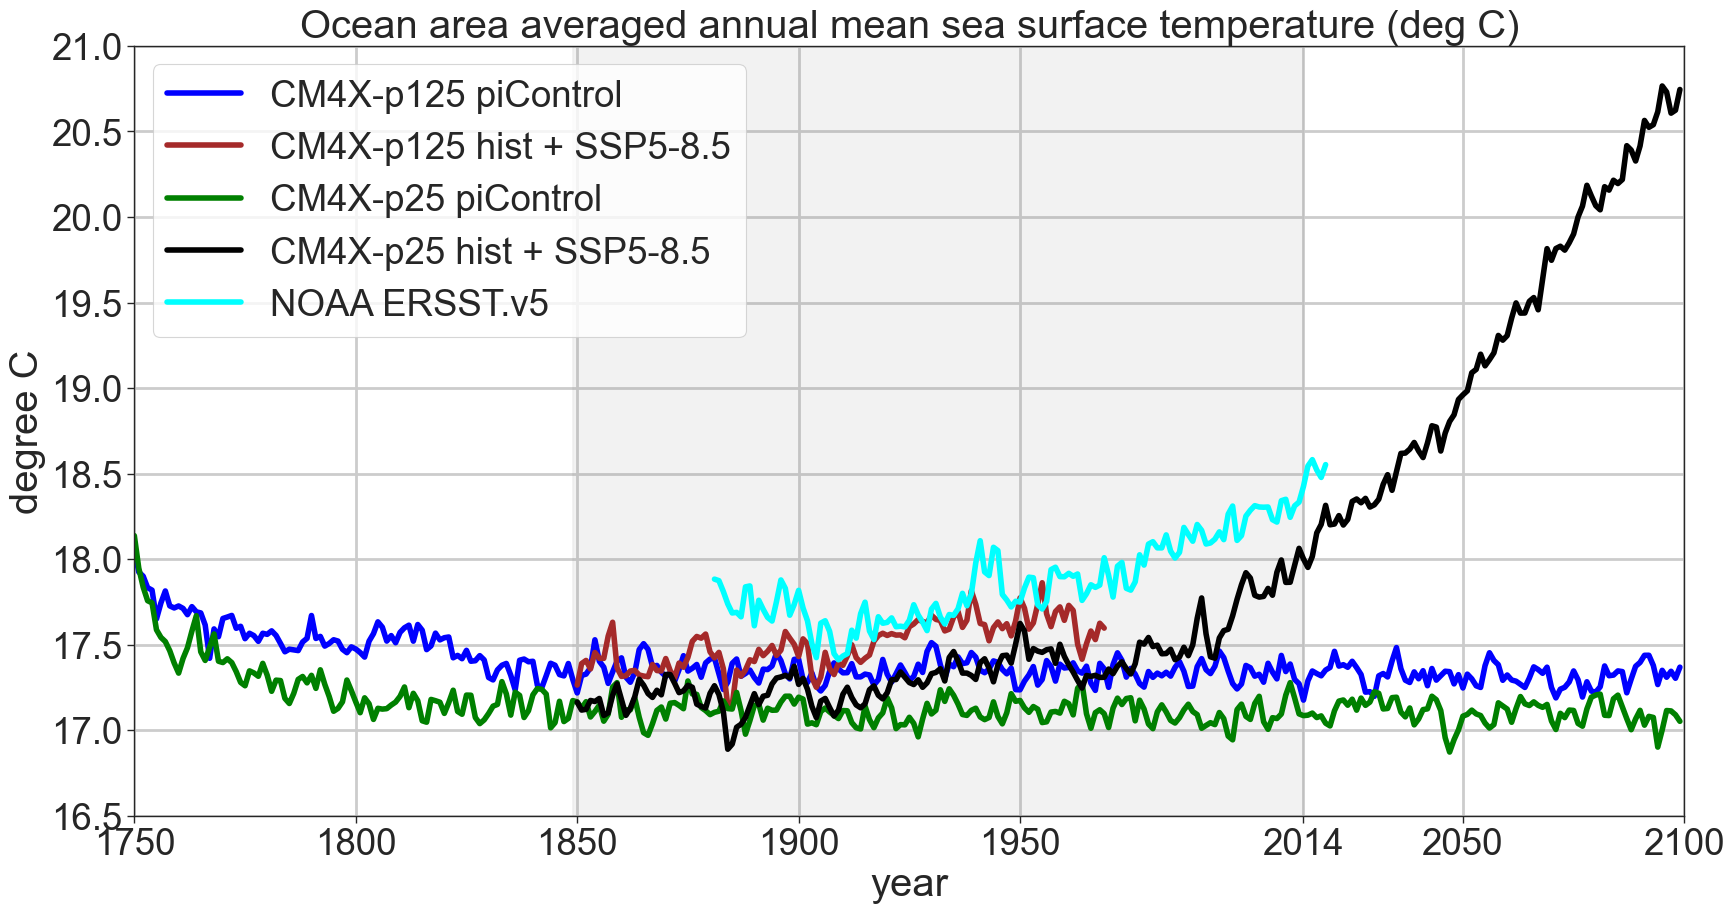

In [16]:
fig, axis = plt.subplots(ncols=1, nrows=1, figsize=(20,10))

tosga_209.plot.line(ax=axis, label='CM4X-p125 piControl',linestyle='solid', color='blue', linewidth=4) 
#tosga_233.plot.line(ax=axis, label='CM4X-p125 hist + SSP5-8.5', linestyle='solid', color='brown', linewidth=1) 
tosga_255.plot.line(ax=axis, label='CM4X-p125 hist + SSP5-8.5', linestyle='solid', color='brown', linewidth=4) 
tosga_210_230.plot.line(ax=axis, label='CM4X-p25 piControl',linestyle='solid', color='green', linewidth=4) 
tosga_231_232.plot.line(ax=axis, label='CM4X-p25 hist + SSP5-8.5',linestyle='solid', color='black', linewidth=4) 
oisst_weighted_mean[27:].plot.line(ax=axis, label='NOAA ERSST.v5',linestyle='solid', color='cyan', linewidth=4) 

axis.legend(loc='upper left')
axis.set_ylim([16.5,21])
axis.set_xlim(1750,2100)
axis.set_ylabel('degree C')
axis.set_xlabel('year')
axis.grid(linewidth=2)
plt.xticks(ticks=[1750, 1800, 1850, 1900, 1950, 2014, 2050, 2100])

axis.fill_between(tosga_209['year'].values, 0, tosga_209['year'].values,
                  where=((tosga_209['year'] >= 1850) & (tosga_209['year'] <= 2014)),
                  interpolate=True, color='gray', alpha=0.1)

#plt.vlines(x=-5.5e4,ymin=3.5,ymax=3.6, color= 'purple', linestyle='solid')
#plt.vlines(x=3.7e3,ymin=3.5,ymax=3.8, color= 'purple', linestyle='solid')
axis.set_title('Ocean area averaged annual mean sea surface temperature (deg C)')
fig.savefig('tosga_CM4X.png', bbox_inches='tight', dpi=200)



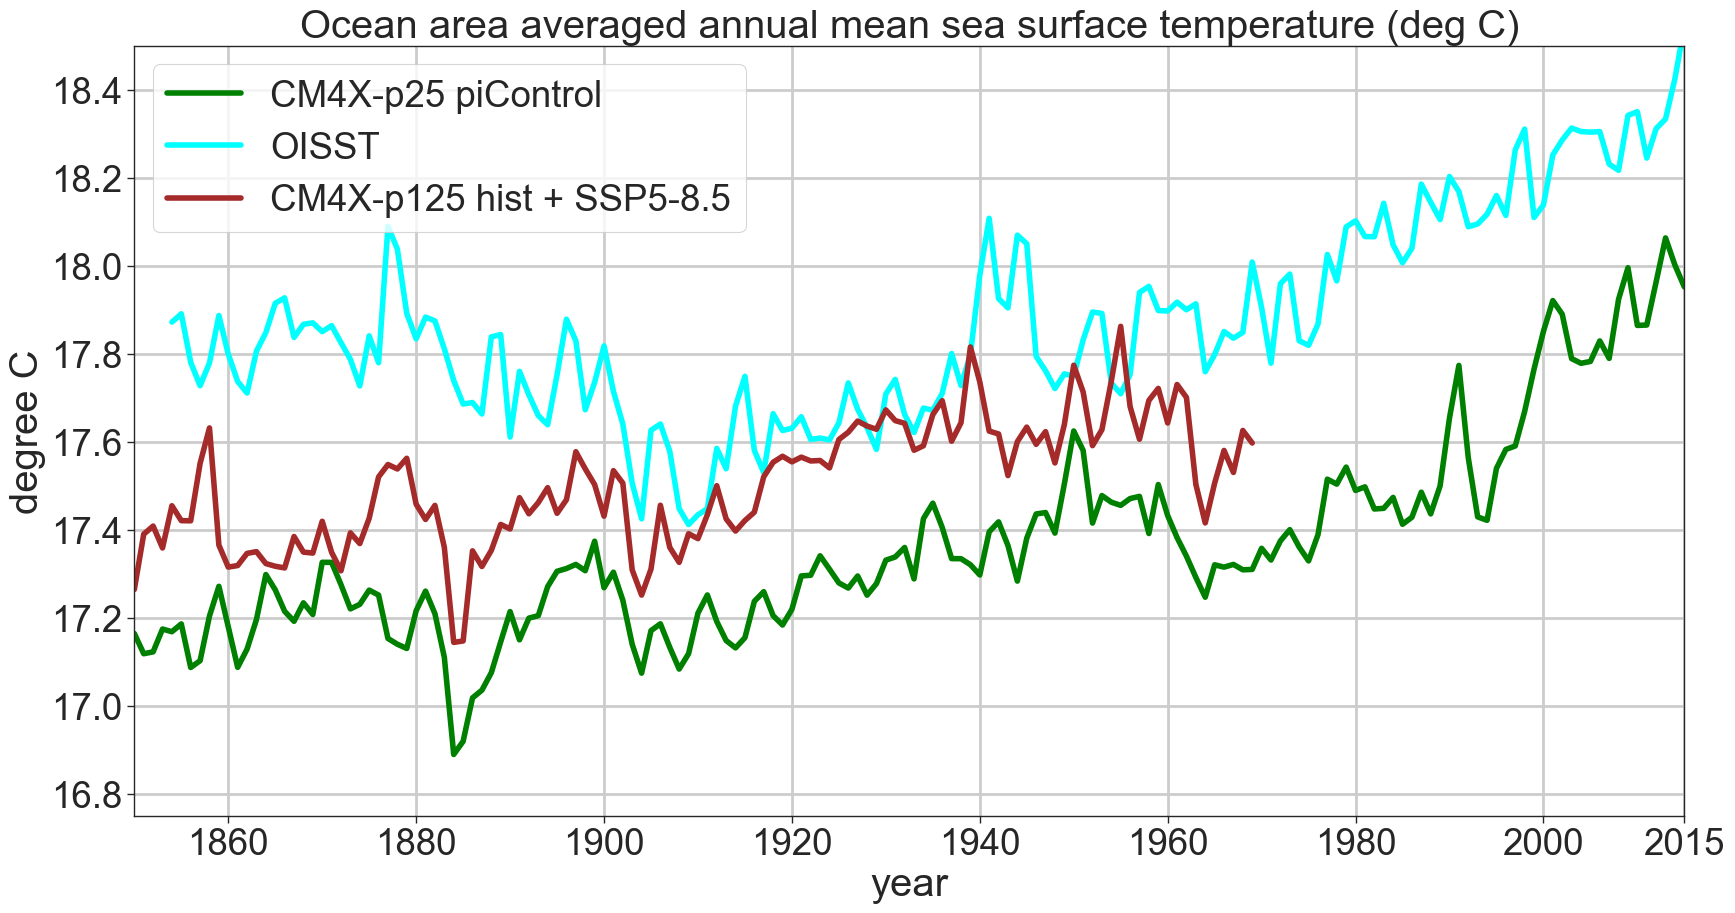

In [17]:
fig, axis = plt.subplots(ncols=1, nrows=1, figsize=(20,10))

tosga_231_232.plot.line(ax=axis, label='CM4X-p25 piControl',linestyle='solid', color='green', linewidth=4) 
oisst_weighted_mean.plot.line(ax=axis, label='OISST',linestyle='solid', color='cyan', linewidth=4) 
tosga_255.plot.line(ax=axis, label='CM4X-p125 hist + SSP5-8.5', linestyle='solid', color='brown', linewidth=4) 

axis.legend(loc='upper left')
axis.set_ylim([16.75,18.5])
axis.set_xlim(1850,2015)
axis.set_ylabel('degree C')
axis.set_xlabel('year')
axis.grid(linewidth=2)
plt.xticks(ticks=[1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000, 2015])
#plt.vlines(x=-5.5e4,ymin=3.5,ymax=3.6, color= 'purple', linestyle='solid')
#plt.vlines(x=3.7e3,ymin=3.5,ymax=3.8, color= 'purple', linestyle='solid')
axis.set_title('Ocean area averaged annual mean sea surface temperature (deg C)')
fig.savefig('tosga_CM4X_absolute.png', bbox_inches='tight', dpi=200)



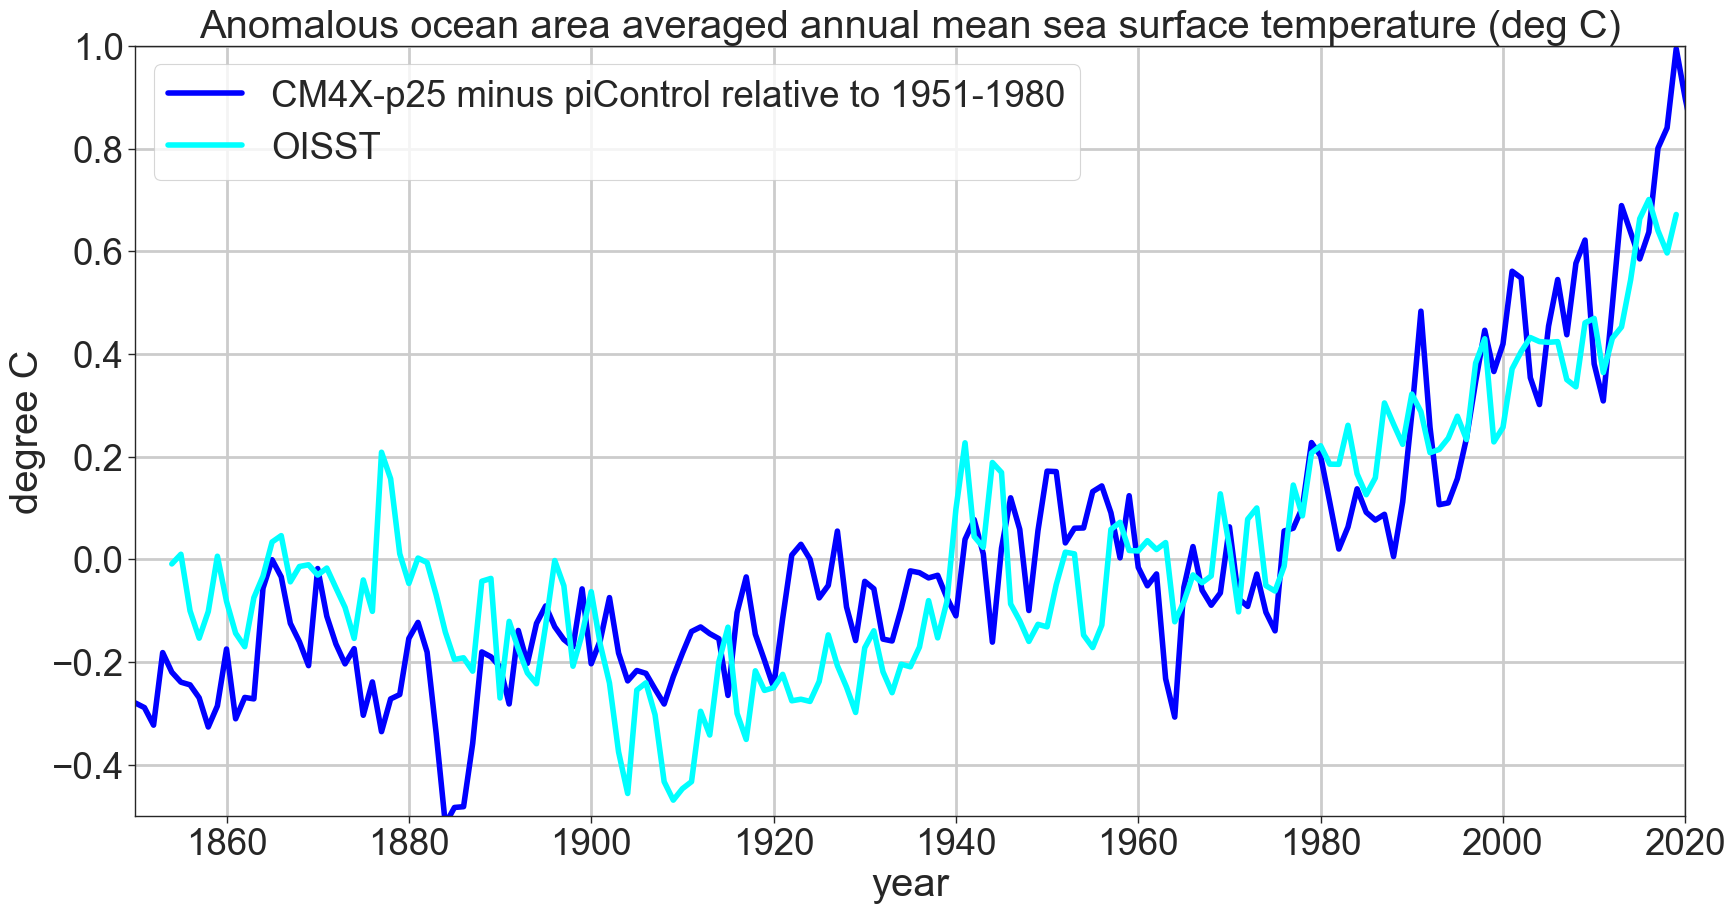

In [18]:
fig, axis = plt.subplots(ncols=1, nrows=1, figsize=(20,10))

tosga_p25_anom.plot.line(ax=axis, label='CM4X-p25 minus piControl relative to 1951-1980',linestyle='solid', color='blue', linewidth=4) 
oisst_anom.plot.line(ax=axis, label='OISST',linestyle='solid', color='cyan', linewidth=4) 
#tosga_hur_anom.plot.line(ax=axis, label='Hurrel SST relative to 1900-2000',linestyle='solid', color='red', linewidth=4) 

axis.legend(loc='upper left')
axis.set_ylim([-0.5, 1.])
axis.set_xlim(1850,2015)
axis.set_ylabel('degree C')
axis.set_xlabel('year')
axis.grid(linewidth=2)
plt.xticks(ticks=[1860, 1880, 1900, 1920, 1940, 1960, 1980, 2000, 2020])
#plt.vlines(x=-5.5e4,ymin=3.5,ymax=3.6, color= 'purple', linestyle='solid')
#plt.vlines(x=3.7e3,ymin=3.5,ymax=3.8, color= 'purple', linestyle='solid')
axis.set_title('Anomalous ocean area averaged annual mean sea surface temperature (deg C)')
fig.savefig('tosga_CM4X_anom.png', bbox_inches='tight', dpi=200)

